<h1>Trabajo Práctico 3: detectando barcos en el agua!<h1>

In [1]:
import numpy as np # Manejo de array
import pandas as pd # Trabajar con tablas
import os
import matplotlib.pyplot as plt # Plotear grafico 
from PIL import Image # Trabajar con imágenes (abrir, transformarla, dibujarle arriba, convertir formato)
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from sklearn.model_selection import train_test_split
# classification_report = Crear un informe de texto que muestre las principales métricas de clasificación.
# accuracy_score = calcular accuracy
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
#cuda para correr en nvidia
from pathlib import Path # Manejar path (un archivo en un lugar, crear/borrar, etc.)
#from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [2]:
# configuraciones generales de las imagenes
PICTURE_SIZE = 80
CHANNELS = 'rgb' # canales
PATH_IMAGE = 'imagenes_tp3_cv/' #ubicación de las imágenes

INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend(['%s%i' % (color, i) 
                              for i in range(PICTURE_SIZE ** 2)]) # For 80 * 80
    print(color)

print(len(INPUT_COLUMNS))
print(INPUT_COLUMNS)

    

r
g
b
19200
['r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27', 'r28', 'r29', 'r30', 'r31', 'r32', 'r33', 'r34', 'r35', 'r36', 'r37', 'r38', 'r39', 'r40', 'r41', 'r42', 'r43', 'r44', 'r45', 'r46', 'r47', 'r48', 'r49', 'r50', 'r51', 'r52', 'r53', 'r54', 'r55', 'r56', 'r57', 'r58', 'r59', 'r60', 'r61', 'r62', 'r63', 'r64', 'r65', 'r66', 'r67', 'r68', 'r69', 'r70', 'r71', 'r72', 'r73', 'r74', 'r75', 'r76', 'r77', 'r78', 'r79', 'r80', 'r81', 'r82', 'r83', 'r84', 'r85', 'r86', 'r87', 'r88', 'r89', 'r90', 'r91', 'r92', 'r93', 'r94', 'r95', 'r96', 'r97', 'r98', 'r99', 'r100', 'r101', 'r102', 'r103', 'r104', 'r105', 'r106', 'r107', 'r108', 'r109', 'r110', 'r111', 'r112', 'r113', 'r114', 'r115', 'r116', 'r117', 'r118', 'r119', 'r120', 'r121', 'r122', 'r123', 'r124', 'r125', 'r126', 'r127', 'r128', 'r129', 'r130', 'r131', 'r132', 'r133', 'r134', 'r135', 'r136', '

<p>Cada fila es una imagen. <p>
<p>La imagen tiene 80 x 80 pixeles, y cada pixel tiene 3 valores, entonces tenemos 80 x 80 x 3 = 19.200‬ columnas.<p>

Imagen


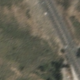

In [3]:
print('Imagen')
imagen = Image.open(PATH_IMAGE + '0__20160622_170157_0c64__-122.485753590087_37.835957669247584.png')
imagen


In [4]:
print('Todas las Imagenes')

for archivo in os.listdir(PATH_IMAGE):
    #print(os.path.join(PATH_IMAGE,archivo)) # Lista Nombre de la carpeta y nombre de la imagen
    #print(os.path.join(archivo)) # Solo Nombre de la imagen
    #print(archivo) # Solo Nombre de la imagen
    # Mostrar todas las imagenes (que reviente la memoria)
    #imagen = Image.open(PATH_IMAGE + os.path.join(archivo))
    #print(imagen)    
    # jajaja no reventó
    

SyntaxError: unexpected EOF while parsing (<ipython-input-4-1d8a9d415f08>, line 11)

In [5]:
cant_image = len(os.listdir(PATH_IMAGE)) 
print('Hay ' + str(cant_image) + ' imagenes en la carpeta ' + PATH_IMAGE)

Hay 4000 imagenes en la carpeta imagenes_tp3_cv/


In [6]:
#choclo de numeros

# hay que hacer 
# -> lista de tuplas donde estan los 3 colores para cada tupla
# -> se lo pasamos a np que es n x n x n y convertilo a un registro (se debe generar el data frame)

# una vez generado el dataframe, generar el .pkl para no tener que general el dataframe de nuevo

In [7]:
# cultivnado el maiz para obtener el choclo
# https://pillow.readthedocs.io/en/stable/

In [8]:
# cambiar el color de un pixel usando Pillow (transformar cada imagen a rojo, verde y azul)
# http://nightdeveloper.net/cambiar-usando-python/
#https://github.com/python-pillow/Pillow/issues/2601

imagen = Image.open('Barco.png')

pixeles = list(imagen.getdata())

print(len(pixeles))
pixeles # -> lista de tuplas donde estan los 3 colores para cada tupla (cada tupla va a ser un pixel)

# replicar por cada imagen que se tenga


6400


[(113, 121, 114),
 (114, 121, 114),
 (115, 122, 115),
 (113, 122, 115),
 (113, 121, 114),
 (116, 124, 118),
 (120, 128, 122),
 (119, 126, 119),
 (120, 128, 121),
 (117, 126, 118),
 (115, 125, 115),
 (128, 136, 127),
 (118, 126, 117),
 (113, 120, 112),
 (114, 121, 113),
 (113, 118, 111),
 (114, 120, 113),
 (116, 122, 115),
 (116, 122, 116),
 (115, 120, 115),
 (115, 121, 116),
 (116, 121, 116),
 (112, 118, 111),
 (115, 122, 114),
 (116, 123, 116),
 (116, 122, 115),
 (120, 125, 118),
 (116, 122, 114),
 (115, 121, 114),
 (119, 125, 118),
 (117, 123, 116),
 (115, 122, 115),
 (115, 122, 114),
 (114, 121, 112),
 (118, 125, 116),
 (106, 114, 106),
 (98, 106, 98),
 (114, 120, 113),
 (117, 124, 116),
 (115, 123, 115),
 (115, 122, 115),
 (115, 123, 116),
 (115, 123, 116),
 (112, 121, 113),
 (106, 116, 106),
 (110, 117, 109),
 (113, 119, 114),
 (113, 120, 115),
 (114, 120, 114),
 (116, 122, 116),
 (115, 121, 115),
 (112, 119, 112),
 (114, 121, 114),
 (110, 118, 111),
 (109, 117, 110),
 (110, 117, 

""" No borrar

pixeles = imagen_1.load()
#imagen.fp #BufferedReader

for fila in range(PICTURE_SIZE):
    for caluman in range(PICTURE_SIZE):
        #pixeles[fila,caluman] = (255,00,00)
         print(pixeles[fila,caluman]) # RBG de la imagen
         

#imagen_1.save("nueva_imagen.png")
#imagen_ = Image.open('nueva_imagen.png')
#imagen_

"""

In [9]:
# Ahora como metemos el maiz dentro del choclo
# vamos a ver que sale

# primero generamos el dataframe
columns_DF = INPUT_COLUMNS + ['Barco', 'Name_Image']
newDF = pd.DataFrame(index=range(len(os.listdir(PATH_IMAGE))), columns = columns_DF)

newDF.head(5)

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b6392,b6393,b6394,b6395,b6396,b6397,b6398,b6399,Barco,Name_Image
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#prueba
count_pixel=0    
count_image=0

# recorro todas las imagenes de la carpeta
for archivo in os.listdir(PATH_IMAGE):
    #print(newDF.iloc[count_image, 65])
    #print(archivo)
    
    imagen = Image.open(PATH_IMAGE + archivo) # abro la imagen
    pixeles = list(imagen.getdata()) # trasformo a pixeles rgb
   
    #recorro cada pixel
    for pixel in pixeles:
        #print(str(count_image) + ' - ' + str(count_pixel))
        #print('r' + str(count_pixel))
        #rojo, verde, azul = pixel
        #newDF.loc[count_image, 'Barco'] = rojo
        #newDF[count_image]['g' + str(count_pixel)] = verde
        #newDF[count_image]['b' + str(count_pixel)] = azul
        count_pixel += 1

    count_image += 1
    break

In [12]:
# ahora completamos el dataFrame
count_pixel=0    
count_image=0

# recorro todas las imagenes de la carpeta
for archivo in os.listdir(PATH_IMAGE):
    #print(newDF.iloc[count_image, 65])
    #print(archivo)
    
    newDF.loc[count_image, 'Name_Image'] = archivo #nombre del archivo
    
    #imagen = Image.open(PATH_IMAGE + archivo) # abro la imagen
    #pixeles = list(imagen.getdata()) # trasformo a pixeles rgb
    
    #recorro cada pixel
    #for pixel in pixeles:
        #print(str(count_image) + ' - ' + str(count_pixel))
        
    #    rojo, verde, azul = pixel
    #    newDF.loc[count_image, ('r' + str(count_pixel))] = rojo
        #newDF[count_image]['g' + str(count_pixel)] = verde
        #newDF[count_image]['b' + str(count_pixel)] = azul
    #    count_pixel += 1

    count_image += 1
    if count_image == 3:
        break
    #print(newDF.loc[count_image,'Name_Image'])
     #imagen.closed() # Cierra la imagen
    
    
  
    
    # para probar si la imagen la transforma a rojo
newDF.head(5)

0__20171023_190146_0f2e__-122.24074702903093_37.73726523972584.png
0__20170609_180750_101b__-122.40598612239049_37.80905694311659.png
0__20170805_180925_1001__-122.06884314323169_37.72621741151038.png


,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b6392,b6393,b6394,b6395,b6396,b6397,b6398,b6399,Barco,Name_Image
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0__20171023_190146_0f2e__-122.24074702903093_3...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0__20170609_180750_101b__-122.40598612239049_3...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0__20170805_180925_1001__-122.06884314323169_3...
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Parámetros y conceptos más comunes
Input size W: el tamaño de la entrada
filters: cantidad de filtros
kernel_size F: tamaño del kernel; se establece el ancho y alto, la profundidad depende de las entradas
strides S: la cantidad de pasos que muevo el kernel
padding P: agrega ceros en los bordes para mantener el tamaño original
activation: función de activación aplicada pixel a pixel
La cantidad de neuronas de salida es (W - F + 2P)/S + 1